# Toy model

This analysis describes the reasoning for how to build the toy model used in xrb_layered, so that it resembles as closely as possible the MESA model. The code to build the model is in toy_atm/. 

### Composition
First we'll try to reproduce the composition with analytical functions for the hydrogen, helium, carbon and iron mass fraction profiles.

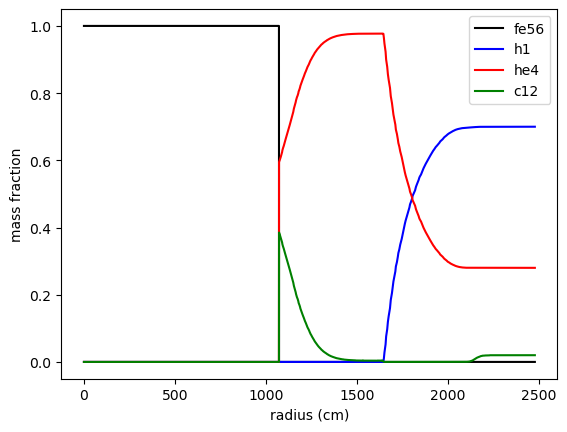

In [1]:
import py_mesa_reader as mr
import numpy as np
import matplotlib.pyplot as plt

# Plot MESA model

prof = mr.MesaData("profile37.data")

def plot_X():
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('radius (cm)')
    ax.set_ylabel('mass fraction')
    ax.plot(prof.R_cm-12e5, prof.fe56, 'k-', label='fe56')
    ax.plot(prof.R_cm-12e5, prof.h1, 'b-', label='h1')
    ax.plot(prof.R_cm-12e5, prof.he4, 'r-', label='he4')
    ax.plot(prof.R_cm-12e5, prof.c12, 'g-', label='c12')
    ax.legend()
    return ax

ax=plot_X()

Fit the h1 mass fraction with a sort of sigmoid function:
$$f(x) = b + \frac{a-b}{(1+(x/x_0)^\alpha)^\beta}$$
which has $f(0)=a$, $f(\infty)=b$, and some sigmoid-like transition around $x=x_0$. $\alpha$ and $\beta$ control the shape of the transition.

/var/folders/9j/c_3j284d3hdd1_xxm340wgzh0000gn/T/ipykernel_75724/2510382295.py:7: RuntimeWarning: invalid value encountered in power
  return b + (a-b)/(1+(x/x0)**alpha)**beta


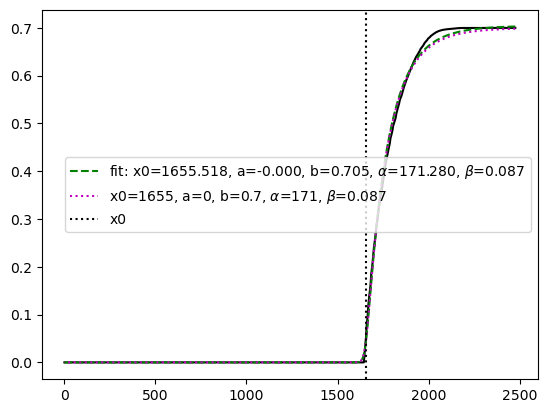

In [2]:
xdata = prof.R_cm-12e5
ydata = prof.h1
ydata[ydata==1e-99] = 0
plt.plot(xdata,ydata,'k-',lw=1.5)

def my_sigmoid(x,x0,a,b,alpha,beta):
    return b + (a-b)/(1+(x/x0)**alpha)**beta

from scipy.optimize import curve_fit
popt, pcov = curve_fit(my_sigmoid, xdata, ydata)
plt.plot(xdata, my_sigmoid(xdata, *popt), 'g--', 
         label=r'fit: x0=%5.3f, a=%5.3f, b=%5.3f, $\alpha$=%5.3f, $\beta$=%5.3f' % tuple(popt))
# print('fit: x0=%5.3f, a=%5.3f, b=%5.3f, alpha=%5.3f, beta=%5.3f' % tuple(popt))

# Rounding the parameters (a=0, b=0.7 of course)
plt.plot(xdata, my_sigmoid(xdata, x0=1655, a=0, b=0.7, alpha=171, beta=0.087), 'm:',
        label=r'x0=1655, a=0, b=0.7, $\alpha$=171, $\beta$=0.087')


plt.axvline(1655,color='k',ls=':',label='x0')
plt.legend()


# The generalised logistic function, with the exponential term (https://en.wikipedia.org/wiki/Generalised_logistic_function)
# is not as intuitive and doesn't work as well it seems
# def func(x,A,K,Q,B,nu):
#     return A + (K-A)/(1+Q*np.exp(-B*x))**nu
# popt, pcov = curve_fit(func, xdata, ydata)
# plt.plot(xdata, func(xdata, *popt), 'r--')
# print('fit: A=%5.3f, K=%5.3f, Q=%5.3f, B=%5.3f, nu=%5.4f' % tuple(popt))

Now he4 and c12 can be fit with a sigmoid of the same shape, but different asymptotes (a & b).

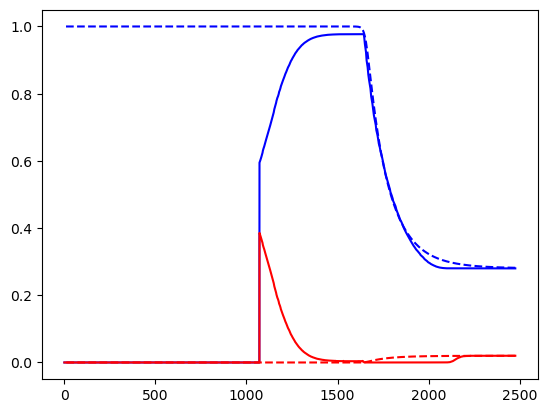

In [3]:
plt.plot(xdata, prof.he4, 'b-')
plt.plot(xdata, prof.c12, 'r-')
plt.plot(xdata, my_sigmoid(xdata, x0=1655, a=1.0, b=0.28, alpha=171, beta=0.087), 'b--')
plt.plot(xdata, my_sigmoid(xdata, x0=1655, a=0.0, b=0.02, alpha=171, beta=0.087), 'r--')

Of course in this simplified model, the He layer is pure He, it has not burned anything to carbon. Also in the H-layer, carbon has not converted to other CNO elements. Putting a network into this, there will be burning for some CNO adjustment, on top of the 3$\alpha$ burning.

In the full model which also includes a $\tanh$ transition from fe56 to he4, just use the tanh as the value of the asymptote $a$ for he4's sigmoid function. h1 and c12 are unchanged. Then the fe56 mass fractions are just 1-sum(X_i).

H_star= 1071.5215855911374


(1021.5215855911374, 1121.5215855911374)

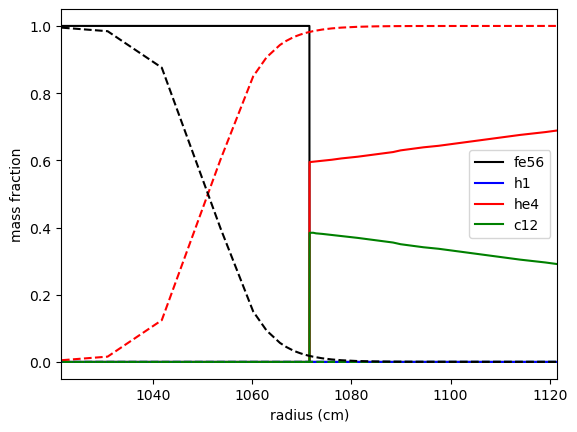

In [4]:
# asymptote mass fractions
ash1_frac = 1
fuel1_frac = 0.7
fuel2_frac = 0.28
fuel3_frac = 0.02

# dimensions
nx = 1024
xmin = 0
xmax = 3072

# tanh
# H_star = 1100
H_star = (prof.R_cm-12e5)[prof.fe56==1][0]
print("H_star=",H_star)
delta = 10 # half width of the tanh

# sigmoid
sig_H = 1655
sig_alpha = 171
sig_beta = 0.087

X_h1  = fuel1_frac * (1 - 1/(1+(xdata/sig_H)**sig_alpha)**sig_beta)
X_c12 = fuel3_frac * (1 - 1/(1+(xdata/sig_H)**sig_alpha)**sig_beta)

a_he4 = 0.5*(1 + np.tanh((xdata - (xmin + H_star - delta) + delta)/delta))
X_he4 = fuel2_frac + (a_he4 - fuel2_frac)/(1+(xdata/sig_H)**sig_alpha)**sig_beta

X_fe56 = 1 - np.sum((X_h1,X_he4,X_c12),axis=0)

ax = plot_X()
ax.plot(xdata, X_h1, 'b--')
ax.plot(xdata, X_he4, 'r--')
ax.plot(xdata, X_c12, 'g--')
ax.plot(xdata, X_fe56, 'k--')

ax.set_xlim([H_star-50,H_star+50])

It's easier to modify the existing toy_atm cpp code if every species uses the same function.

In [5]:
# This is the python equivalent to how toy_atm/init_1d.H sets the composition of all species

species = ['h1','he4','c12','fe56']
xn_star = {spec:0.0 for spec in species}
xn_layer1 = {spec:0.0 for spec in species}
xn_layer2 = {spec:0.0 for spec in species}

xn_star['fe56'] = ash1_frac

xn_layer1['he4'] = 1.0  # hardcoded fraction of 1

xn_layer2['h1'] = fuel1_frac
xn_layer2['he4'] = fuel2_frac
xn_layer2['c12'] = fuel3_frac

def X(spec):
    a = xn_star[spec] + 0.5 * (xn_layer1[spec]-xn_star[spec]) * \
                (1 + np.tanh((xdata - (xmin + H_star - delta) + delta)/delta))
    
    return xn_layer2[spec] + (a - xn_layer2[spec])/(1+(xdata/sig_H)**sig_alpha)**sig_beta

# ax = plot_X()

sumX = np.zeros(len(xdata))
for spec,color in zip(species,('b','r','g','k')):
    xi = X(spec)
    sumX += xi
    # ax.plot(xdata, xi, color=color, ls='--')
    
print("Sum of mass-fractions")
print(sumX)
print("min:",np.min(sumX))

Sum of mass-fractions
[1. 1. 1. ... 1. 1. 1.]
min: 0.9999999999999999


tanh's and sigmoids of the same shape nicely sum up to 1. No need to set fe56 to 1-sum(X_i)..

### Thermal state
Next we approximate the thermal state of the envelope, starting with isothermal at the base, adiabatic at the bottom of the helium zone, then a constant flux radiative envelope at the top.

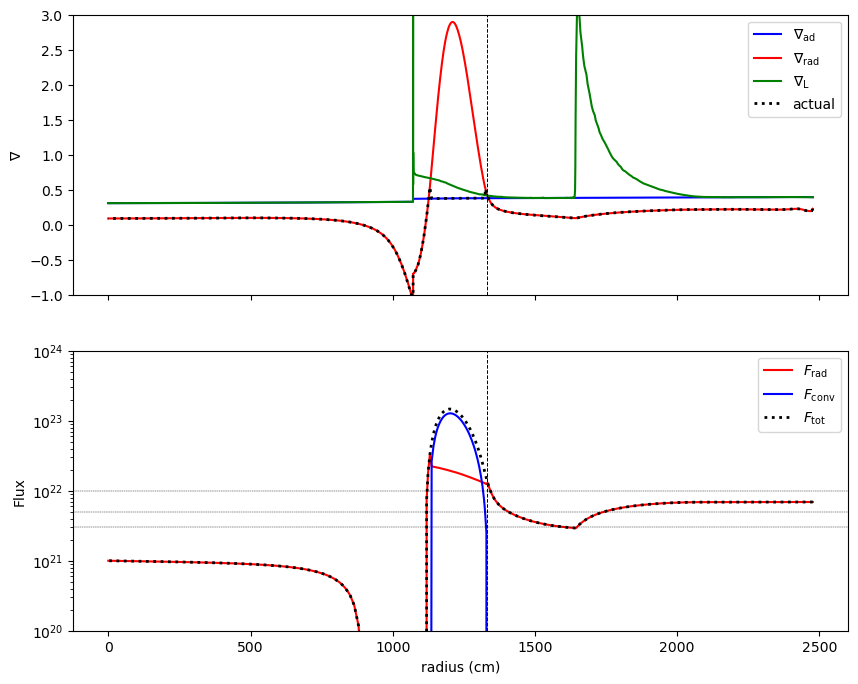

In [6]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(10,8))
ax2.set_xlabel('radius (cm)')
ax1.set_ylabel(r'$\nabla$')
ax1.set_ylim([-1,3])
ax1.plot(prof.R_cm-12e5, prof.grada, 'b-', label=r'$\nabla_{\rm ad}$')
ax1.plot(prof.R_cm-12e5, prof.gradr, 'r-', label=r'$\nabla_{\rm rad}$')
ax1.plot(prof.R_cm-12e5, prof.gradL, 'g-', label=r'$\nabla_{\rm L}$')

gradT = np.diff(prof.logT)/np.diff(prof.logP)
ax1.plot(prof.R_cm[1:]-12e5, gradT, 'k:', label='actual', lw=2)

ax1.legend()

H_rad = 1330
ax1.axvline(H_rad, color='k', ls='--', lw=0.7)

# zoom into the convective zone to see semiconvective boundaries
# ax.set_xlim([1000,1400])
# ax.set_ylim([0.3,0.7])

Lsun = 3.846e33
area = 4*np.pi*12e5**2
ax2.set_ylabel('Flux')
ax2.semilogy(prof.R_cm-12e5, prof.Lrad*Lsun/area, 'r-', label=r'$F_{\rm rad}$')
ax2.semilogy(prof.R_cm-12e5, (prof.luminosity-prof.Lrad)*Lsun/area, 'b-', label=r'$F_{\rm conv}$')
ax2.semilogy(prof.R_cm-12e5, prof.luminosity*Lsun/area, 'k:', label=r'$F_{\rm tot}$', lw=2)
ax2.legend()
ax2.axvline(H_rad, color='k', ls='--', lw=0.7)
ax2.set_ylim([1e20,1e24])

ax2.axhline(3e21, color='k', ls='--', lw=0.3)
ax2.axhline(5e21, color='k', ls='--', lw=0.3)
ax2.axhline(1e22, color='k', ls='--', lw=0.3)

The envelope goes from $\nabla=\nabla_r<\nabla_a$ (stable/radiative), to $\nabla_a<\nabla<\nabla_L$ (unstable Schwarzschild, stable Ledoux, semiconvective) at $\sim 1125$cm, to $\nabla=\nabla_a<\nabla_r$ (unstable/fully convective), to semiconvective again at $\sim 1340$cm, then radiative to the top.

However, the top part of the atmosphere is not at constant flux, because there are reactions. We'll use constant flux anyway, and test different values to see which one matches best.

### Input parameters for the toy model

We also need to specify the temperature of the star, the temperature and density at the base of the isentropic layer.  We use the MESA model as a guide.

Text(300, 1000000.0, 'dens_base')

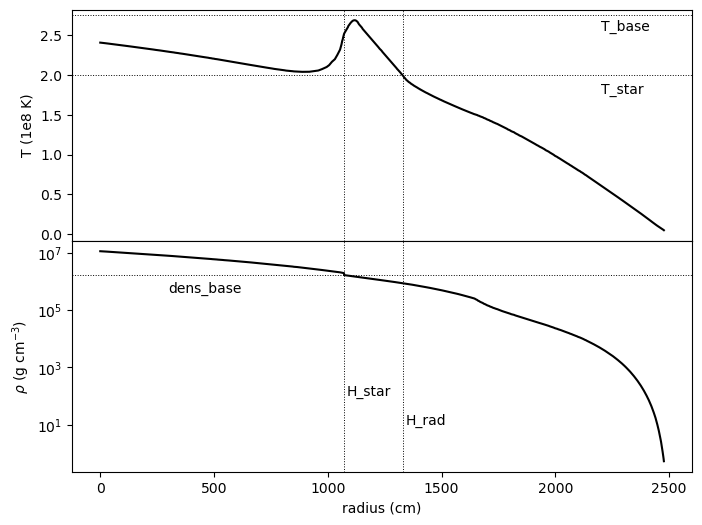

In [7]:
T_star = 2e8
T_base = 2.75e8
rho_base = 1.7e6

def plot_rhoT():
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)
    fig.subplots_adjust(hspace=0)
    ax2.set_xlabel('radius (cm)')
    ax1.set_ylabel(r"T (1e8 K)")
    ax2.set_ylabel(r"$\rho$ (g cm$^{-3}$)")
    ax1.plot(prof.R_cm-12e5, prof.T/1e8, 'k-', label='MESA')
    ax2.semilogy(prof.R_cm-12e5, prof.Rho, 'k-')
    return fig,ax1,ax2

fig,ax1,ax2 = plot_rhoT()

for ax in (ax1,ax2):
    ax.axvline(H_star,color='k',ls=':',lw=0.7)
    ax.axvline(H_rad,color='k',ls=':',lw=0.7)
ax2.text(H_star+10,100,"H_star",ha='left')
ax2.text(H_rad+10,10,"H_rad",ha='left')

ax1.axhline(T_star/1e8,color='k',ls=':',lw=0.7)
ax1.text(2200,0.95*T_star/1e8,"T_star",va='top')

ax1.axhline(T_base/1e8,color='k',ls=':',lw=0.7)
ax1.text(2200,0.98*T_base/1e8,"T_base",va='top')

ax2.axhline(rho_base,color='k',ls=':',lw=0.7)
ax2.text(300,1e6,"dens_base",va='top')

# The result

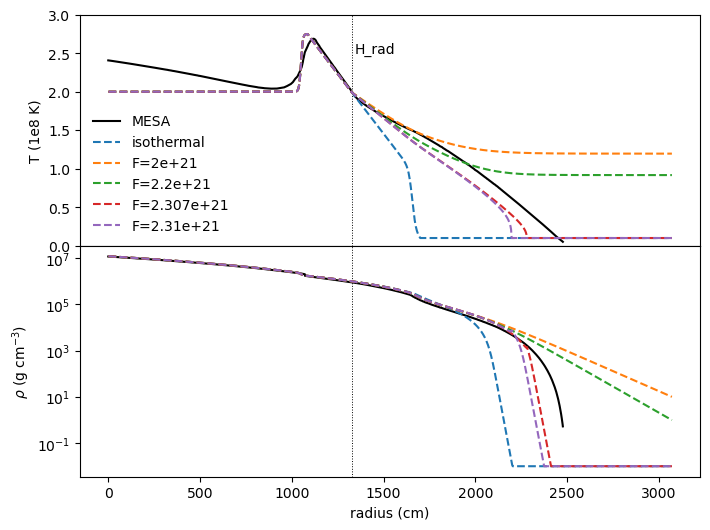

In [8]:
def load_model(filename):
    all_data = np.loadtxt("toy_atm/all_models/"+filename, skiprows=26).T
    names = ["density","temperature","pressure","hydrogen-1","helium-4","carbon-12","carbon-13","nitrogen-13","nitrogen-14","nitrogen-15","oxygen-14","oxygen-15","oxygen-16","oxygen-17","oxygen-18","fluorine-17","fluorine-18","fluorine-19","neon-18","neon-19","neon-20","magnesium-22","magnesium-24","iron-56"]
    data = {name:all_data[i+1] for i,name in enumerate(names)}
    data["height"] = all_data[0]
    return data

fig,ax1,ax2 = plot_rhoT()
for ax in (ax1,ax2):
    ax.axvline(H_rad,color='k',ls=':',lw=0.7)
ax1.text(H_rad+10,2.5,"H_rad",ha='left')


# 
F = ["2e+21","2.2e+21","2.307e+21","2.31e+21"]

filenames = ["toy_xrb_layered_isothermal_3cm.hse"] + \
            ["toy_xrb_layered_Frad_"+f+"_3cm.hse" for f in F]
labels = ["isothermal"] + \
         ["F="+f for f in F]

for fname,label in zip(filenames,labels):
#     print(fname)
    model = load_model(fname)

    ax1.plot(model["height"], model["temperature"]/1e8, ls='--', label=label)
    ax2.semilogy(model["height"], model["density"], ls='--')

ax1.legend(loc=3,frameon=False)
ax1.set_ylim([0,3])
# ax2.set_ylim([1e6,3e6])

# fig.savefig("Trho.png",bbox_inches="tight",dpi=500,transparent=False,facecolor='white')
plt.show()

Clearly, the temperature profile in the radiative zone is very sensitive to the value of the flux (makes sense, $\nabla T^4\sim F$).  It's hard to get at good fit, because the flux in the MESA profile is not constant in the outer layers (see flux-radius plot above).  In the helium layer, there is little burning, so the T profile is shallow. In the hydrogen layer, there is hot CNO throughout, so the T profile is initially steep.

For the MAESTROeX simulation, we will use the F=2.307e21 model, which has the right gradient in the outer layers (although it's colder than MESA by some offset).  We don't want to use a higher flux model because the top would be too heavy.

The composition profile is indenpendent of the HSE state, so it's the same for all models (see plot below).

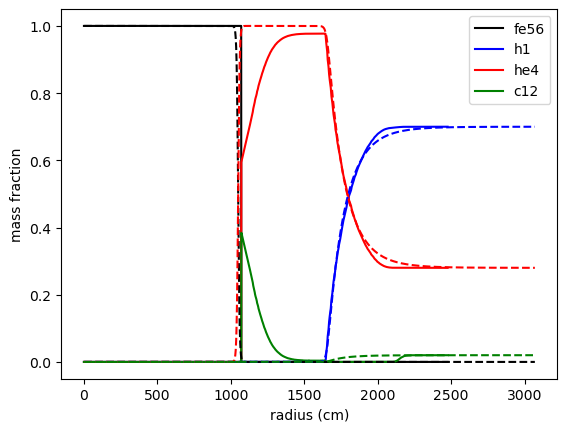

In [9]:
ax = plot_X()
ax.plot(model["height"], model["iron-56"], 'k--')
ax.plot(model["height"], model["hydrogen-1"], 'b--')
ax.plot(model["height"], model["helium-4"], 'r--')
ax.plot(model["height"], model["carbon-12"], 'g--')
fig = plt.gcf()
# fig.savefig("X.png",bbox_inches="tight",dpi=500,transparent=False,facecolor='white')